In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_model_optimization as tfmopt
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
dataset= tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = dataset.load_data()

In [4]:
#Divide the data in Train, Test Datasets
(X_train,y_train),(X_test,y_test)=dataset.load_data()

In [5]:
#Print the dimensions of the datasets 
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


# Data Visualization

In [6]:
# Define the classes of the dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


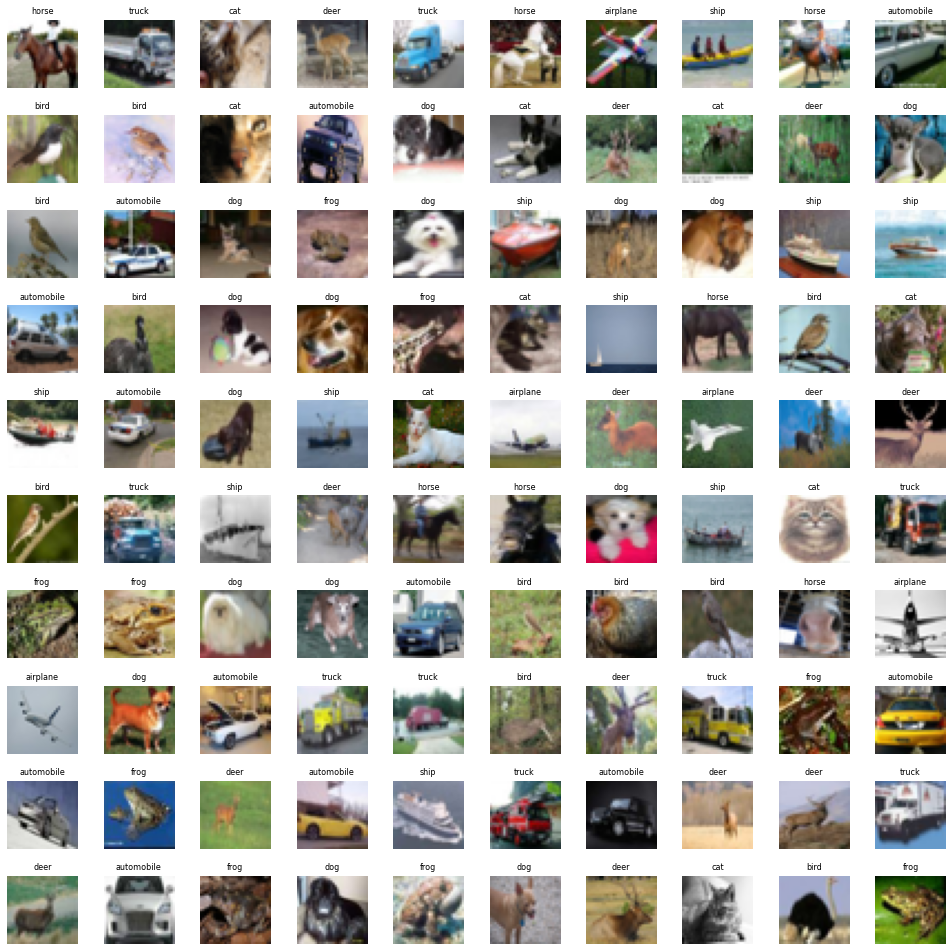

In [7]:
# view more images in a grid format and define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    class_index = int(y_train[index])
    axes[i].set_title(classes[class_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

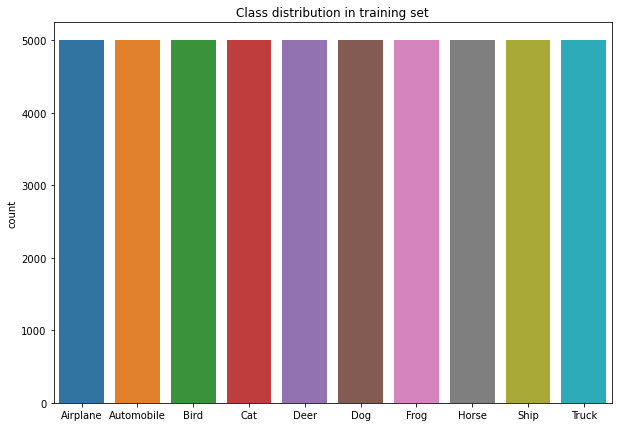

In [8]:
import seaborn as sns
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes_name)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

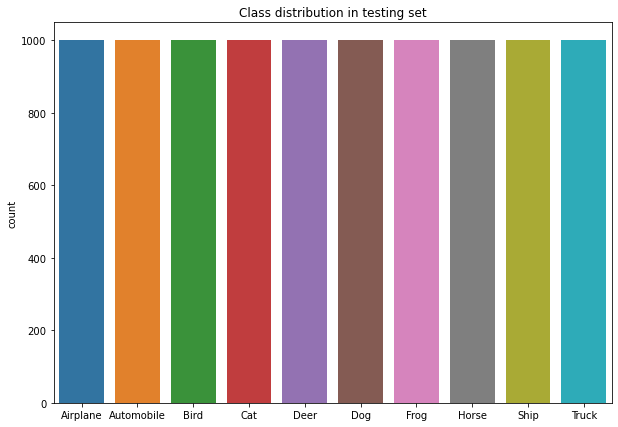

In [9]:
plt.figure(figsize=(10,7))
p = sns.countplot(y_test.flatten())
p.set(xticklabels=classes_name)
plt.title('Class distribution in testing set')

# Data Preprocessing

In [10]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [11]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Convolutional Neural Network Buliding Model 

In [12]:
model = Sequential()
model.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='tanh',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [13]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Model Visualization 

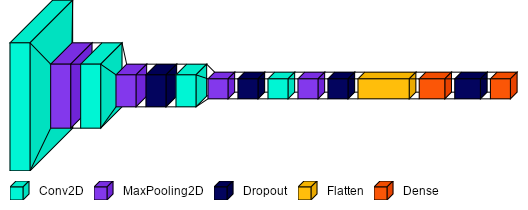

In [16]:
from tensorflow.keras import layers
from PIL import ImageFont
import visualkeras
from collections import defaultdict
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(model, legend=True, font=font,color_map=color_map)

# Model Quantization

In [17]:
quant_aware_model = tfmopt.quantization.keras.quantize_model(model)

In [18]:
quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 32, 32, 64)       3267      
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 16, 16, 64)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 16, 16, 64)       65731     
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 8, 8, 64)         1

In [19]:
quant_aware_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Data Augmentation 

In [22]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [23]:
history= quant_aware_model.fit(train_generator, 
              epochs=50,steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
              callbacks=[tensorboard_callback])

Epoch 1/50
1562/1562 [==============================] - 358s 226ms/step - loss: 1.9324 - accuracy: 0.2694 - precision: 0.5411 - recall: 0.0442 - val_loss: 1.5711 - val_accuracy: 0.4309 - val_precision: 0.7286 - val_recall: 0.1015
Epoch 2/50
1562/1562 [==============================] - 351s 225ms/step - loss: 1.6071 - accuracy: 0.4143 - precision: 0.6236 - recall: 0.1666 - val_loss: 1.3892 - val_accuracy: 0.5054 - val_precision: 0.7577 - val_recall: 0.2189
Epoch 3/50
1562/1562 [==============================] - 337s 216ms/step - loss: 1.4957 - accuracy: 0.4593 - precision: 0.6625 - recall: 0.2294 - val_loss: 1.2872 - val_accuracy: 0.5341 - val_precision: 0.7499 - val_recall: 0.3151
Epoch 4/50
1562/1562 [==============================] - 351s 225ms/step - loss: 1.4226 - accuracy: 0.4891 - precision: 0.6846 - recall: 0.2765 - val_loss: 1.2469 - val_accuracy: 0.5587 - val_precision: 0.7681 - val_recall: 0.3316
Epoch 5/50
1562/1562 [==============================] - 375s 240ms/step - loss: 

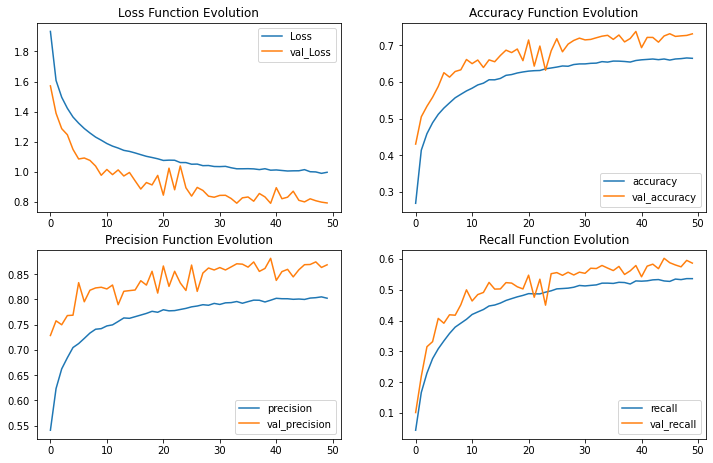

In [25]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

In [26]:
evaluation = quant_aware_model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

313/313 [==============================] - 14s 44ms/step - loss: 0.7943 - accuracy: 0.7317 - precision: 0.8686 - recall: 0.5865
Test Accuracy : 73.17%


In [27]:
y_pred = quant_aware_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

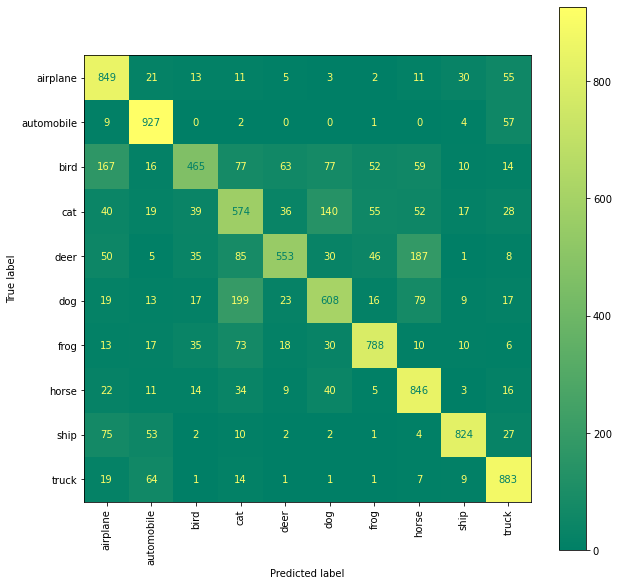

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes )
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.85      0.75      1000
           1       0.81      0.93      0.86      1000
           2       0.75      0.47      0.57      1000
           3       0.53      0.57      0.55      1000
           4       0.78      0.55      0.65      1000
           5       0.65      0.61      0.63      1000
           6       0.81      0.79      0.80      1000
           7       0.67      0.85      0.75      1000
           8       0.90      0.82      0.86      1000
           9       0.79      0.88      0.84      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000

